In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

from data.pamap2.pamap2 import create_pamap2
    
def create_dataset(name, data_type):
    print("creating dataset")
    if name == "pamap2":
        if data_type == "frequency_100":
            x_train, y_train = create_pamap2(data="frequency_100")
            y_train = to_categorical(y_train, len(np.unique(y_train)))
        elif data_type == "nooverlap":
            x_train, y_train = create_pamap2(data="nooverlap")
            y_train = to_categorical(y_train, len(np.unique(y_train)))            

    # 80%, 10%, 10% respectively in train, val, test dataset
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [2]:
def CNN_Set(input_shape, kernel_size, name="Set"):
    
    inputs = tf.keras.layers.Input(input_shape)
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=kernel_size, activation="relu")
    conv2 = tf.keras.layers.Conv1D(32, kernel_size=kernel_size, activation="relu")
    dropout = tf.keras.layers.Dropout(0.5)
    maxpooling = tf.keras.layers.MaxPool1D(pool_size=2)
    flatten = tf.keras.layers.Flatten()
    
    x = tf.keras.layers.TimeDistributed(conv1)(inputs)
    x = tf.keras.layers.TimeDistributed(conv2)(x)
    x = tf.keras.layers.TimeDistributed(dropout)(x)
    x = tf.keras.layers.TimeDistributed(maxpooling)(x)
    x = tf.keras.layers.TimeDistributed(flatten)(x)
    
    model = tf.keras.models.Model(inputs, x, name=name)
    return model

def CNN_BiLSTM(input_shape, outputs):
    
    inputs = tf.keras.layers.Input(input_shape)
    branch_1 = CNN_Set(input_shape, kernel_size=3, name="branch_1")
    branch_2 = CNN_Set(input_shape, kernel_size=7, name="branch_2")
    branch_3 = CNN_Set(input_shape, kernel_size=11, name="branch_3")
    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
    lstm_2=  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))
    dense = tf.keras.layers.Dense(128)
    batch = tf.keras.layers.BatchNormalization()
    output = tf.keras.layers.Dense(outputs, activation="softmax")
    
    
    one = branch_1(inputs)
    two = branch_2(inputs)
    three = branch_3(inputs)
    x = tf.keras.layers.Concatenate()([one, two, three])
    x = lstm_1(x)
    x = lstm_2(x)
    x = dense(x)
    x = batch(x)
    x = output(x)
    
    model = tf.keras.models.Model(inputs, x)
    return model

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

dataset_name = "pamap2"
data_type = "nooverlap"
x_train, y_train, x_val, y_val, x_test, y_test = create_dataset(name=dataset_name, data_type=data_type)

x_train = x_train.reshape(-1, 4, 25, 18)
x_val = x_val.reshape(-1, 4, 25, 18)
x_test = x_test.reshape(-1, 4, 25, 18)

print("x_train.shape : ", x_train.shape, "y_train.shape: ", y_train.shape)
print("x_val.shape   : ", x_val.shape,    "y_val.shape: ", y_val.shape)
print("x_test.shape  : ", x_test.shape,   "y_test.shape: ", y_test.shape)

creating dataset
/home/tolom/20220621/contrastive_frequency
x_train.shape :  (15502, 4, 25, 18) y_train.shape:  (15502, 12)
x_val.shape   :  (1938, 4, 25, 18) y_val.shape:  (1938, 12)
x_test.shape  :  (1938, 4, 25, 18) y_test.shape:  (1938, 12)


In [4]:
learning_rate = 0.001
batch_size = 400
epochs = 100
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [5]:
model = CNN_BiLSTM(x_train.shape[1:], y_train.shape[1])
model.summary()
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val))

2022-06-23 17:08:32.158877: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-23 17:08:35.764594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46722 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:d5:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 25, 18)]  0           []                               
                                                                                                  
 branch_1 (Functional)          (None, 4, 320)       9696        ['input_1[0][0]']                
                                                                                                  
 branch_2 (Functional)          (None, 4, 192)       22496       ['input_1[0][0]']                
                                                                                                  
 branch_3 (Functional)          (None, 4, 64)        35296       ['input_1[0][0]']                
                                                                                              

2022-06-23 17:08:54.550022: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-06-23 17:09:06.345313: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


39/39 [==============================] - 34s 122ms/step - loss: 0.7329 - accuracy: 0.7954 - val_loss: 1.8684 - val_accuracy: 0.7982
Epoch 2/100
39/39 [==============================] - 1s 30ms/step - loss: 0.3884 - accuracy: 0.8925 - val_loss: 1.5233 - val_accuracy: 0.8746
Epoch 3/100
39/39 [==============================] - 1s 37ms/step - loss: 0.3114 - accuracy: 0.9119 - val_loss: 1.1737 - val_accuracy: 0.9056
Epoch 4/100
39/39 [==============================] - 1s 34ms/step - loss: 0.2667 - accuracy: 0.9208 - val_loss: 0.8538 - val_accuracy: 0.9092
Epoch 5/100
39/39 [==============================] - 1s 31ms/step - loss: 0.2426 - accuracy: 0.9269 - val_loss: 0.6529 - val_accuracy: 0.9040
Epoch 6/100
39/39 [==============================] - 1s 36ms/step - loss: 0.2109 - accuracy: 0.9352 - val_loss: 0.4648 - val_accuracy: 0.9102
Epoch 7/100
39/39 [==============================] - 1s 33ms/step - loss: 0.1910 - accuracy: 0.9412 - val_loss: 0.3922 - val_accuracy: 0.9092
Epoch 8/100
39/3

In [6]:
print("maximum train acc : ", max(history.history["accuracy"]))
print("maximum valid acc : ", max(history.history["val_accuracy"]))

test_results = model.evaluate(x_test, y_test)
print("Test Loss & Test Accuracy")
print(test_results)

y_pred = model.predict([x_test])
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
score = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average="macro")
print("f1 score  : ", score)
print("MATRIX")
print(matrix)

maximum train acc :  0.9970971345901489
maximum valid acc :  0.9370484948158264
61/61 [==============================] - 1s 9ms/step - loss: 0.5703 - accuracy: 0.9350
Test Loss & Test Accuracy
[0.5703217387199402, 0.9349845051765442]
f1 score  :  0.9340304823700379
MATRIX
[[187   3   2   0   0   0   0   0   0   0   0   0]
 [  2 167   4   0   0   1   0   0   0   2   9   0]
 [  2   2 175   1   0   0   0   0   0   0   9   0]
 [  2   0   0 227   1   0   4   0   1   1   2   0]
 [  0   0   4   1  91   0   1   1   0   0   0   0]
 [  1   0   0   0   0 153   0   0   2   4   4   0]
 [  0   0   1   0   0   1 185   0   1   0   0   0]
 [  0   1   2   2   0   0   0 108   1   2   1   0]
 [  0   0   3   3   0   0   0   5  89   0   4   1]
 [  0   1   0   0   0   1   1   1   1 156  14   0]
 [  0   0   5   0   0   2   0   0   0   0 229   2]
 [  0   0   0   0   0   1   0   0   1   0   2  45]]


[PRINTING GRAPH]


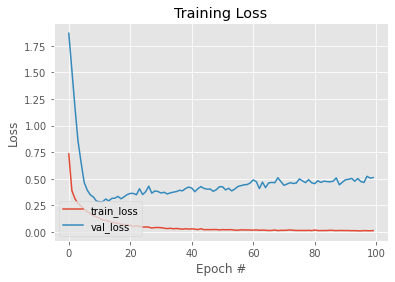

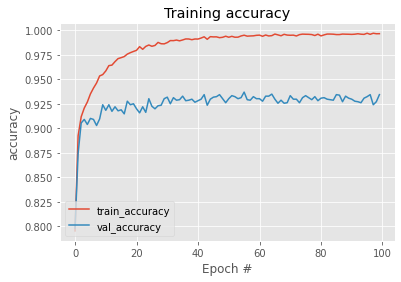

In [7]:
import matplotlib.pyplot as plt
def plot_training_loss(H, plotPath):
    	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	if plotPath is not None:
		plt.savefig(plotPath)
	else:
		plt.show()

def plot_training_acc(H, plotPath):
    	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["accuracy"], label="train_accuracy")
	plt.plot(H.history["val_accuracy"], label="val_accuracy")
	plt.title("Training accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")
	if plotPath is not None:
		plt.savefig(plotPath)
	else:
		plt.show()

print("[PRINTING GRAPH]")
plot_training_loss(history, None)
plot_training_acc(history, None)